# Dataset Split

### Person-Independent Approach: 
**Goal: No channel overlap across train/val/test.**
1. **Hold-out test by channel (70/30)** - Use GroupShuffleSplit (groups = channel_id) to create a train+val pool (70%) and a test set (30%) with zero channel overlap. Note that there is no stratification yet.
2. **Learn bins on the train+val pool (no leakage)** - Compute quantile-based bin edges on view_count to create five equally populated ranges. Derive a 'view_range' column.
3. **Apply the same bins everywhere** - Assign view_range to the train+val pool (for stratification) and to the test set (for reporting), using the same bin edges from step 2.
4. **Make validation (≈10% overall) with SGKF** - From the train+val pool, use StratifiedGroupKFold (stratify on view_range, groups = channel_id) to split out a validation fold, ensuring an overall 60/10/30 split while keeping channels disjoint.

### Person-Dependent Approach:
**Goal: Channels may appear in multiple splits; preserve class balance.**
1. **Hold-out test randomly (70/30)** - Use train_test_split (no stratification yet) to create a train+val pool (70%) and a test set (30%).
2. **Learn bins on the train+val pool** - Compute quantile-based five-bin edges on view_count and create view_range labels on the pool.
3. **Apply the same bins to test** - Label the test set with the same bin edges (for evaluation only).
4. **Make validation (≈10% overall) with stratified split** - Split the pool into train/val using train_test_split with stratify= view_range to achieve 60/10/30 overall.

## Helper Functions

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, train_test_split

# We will create human readable labels which can help us understand the exact view range
def human_labels_from_edges(edges):
    def fmt(x):
        if np.isneginf(x): return "-∞"
        if np.isposinf(x): return "∞"
        x = float(x)
        if x < 1_000:      return f"{int(round(x))}"
        if x < 1_000_000:  return f"{int(round(x/1_000))}K"
        return f"{int(round(x/1_000_000))}M"

    labels = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        if np.isneginf(lo):
            labels.append(f"<{fmt(hi)}")  # First finite upper bound: "<X"
        elif np.isposinf(hi):
            labels.append(f"≥{fmt(lo)}")   # Last open-ended bin: "≥X"
        else:
            labels.append(f"{fmt(lo)}–{fmt(hi)}")   # Closed interval label "X–Y"
    return labels
    
def make_encoded_labels(edges):
    return [f"{i}" for i in range(0, len(edges)-1)]  # Encoded labels from 0 to 4
    
def make_bins_from_train(series, n_bins=5):
    q = np.linspace(0, 1, n_bins + 1)
    edges = np.unique(np.quantile(series.to_numpy(dtype=float), q))   # Form quantile bins
    if len(edges) < 2:
        raise ValueError("Not enough unique values to form bins.")
    edges[0], edges[-1] = -np.inf, np.inf   # Change the lower and upper bounds to open-ended ranges: -∞ and +∞
    labels = human_labels_from_edges(edges)   # Get the human readable edges
    return edges, labels    # Return the ranges and their encoded values
    
def report_counts(name, y):
    counts = pd.Series(y).value_counts(dropna=False).sort_index()
    print(f"\n{name} class counts:")
    print(counts.to_string())

# Hold out a test set by channel, no stratification, no leakage -> Keep videos from one group in one set only
def initial_test_split_person_independent(df, test_size=0.30, group_col="channel_id", random_state=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    train_idx, test_idx = next(gss.split(df, groups=groups))
    return df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# Hold out a test set, no stratification, no leakage -> Randomly split
def initial_test_split_person_dependent(df, test_size=0.30, random_state=42):
    idx = np.arange(len(df))
    train_idx, test_idx = train_test_split(
        idx, test_size=test_size, shuffle=True, random_state=random_state
    )
    return df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# Person-Independent Split

In [11]:
def person_independent_split(
    df,
    test_size=0.30,
    val_size=0.10,              # overall desired val share (e.g., 0.10 when you want 60/10/30)
    group_col="channel_id",
    count_col="view_count",
    n_bins=5,
    random_state=42
):
    
    # 1) Hold out test by groups
    trainval_df, test_df = initial_test_split_person_independent(
        df, test_size=test_size, group_col=group_col, random_state=random_state
    )

    # 2) Learn bins from train+val only (prevents using any test info to define bins)
    edges, labels = make_bins_from_train(trainval_df[count_col], n_bins=n_bins)

    # 3) Label train+val and test (test labels are for evaluation/reporting only)
    trainval_df = trainval_df.copy()
    test_df = test_df.copy()
    trainval_df["view_range_ind"] = pd.cut(trainval_df[count_col], bins=edges, labels=labels, include_lowest=True) # Human-readable categorical labels
    test_df["view_range_ind"]     = pd.cut(test_df[count_col],     bins=edges, labels=labels, include_lowest=True)
    df["view_range_ind"] = pd.cut(df[count_col], bins=edges, labels=labels, include_lowest=True) # Update the full df as well - Save for later use 

    enc_pi = make_encoded_labels(edges) # Encoded labels as strings "0","1",... matching the bins (stable ordinal codes)
    trainval_df = trainval_df.copy()
    test_df = test_df.copy()
    trainval_df["view_range_enc_ind"] = pd.cut(trainval_df[count_col], bins=edges, labels=enc_pi, include_lowest=True) # Create the view range encoded column
    test_df["view_range_enc_ind"]     = pd.cut(test_df[count_col],     bins=edges, labels=enc_pi, include_lowest=True)
    df["view_range_enc_ind"] = pd.cut(df[count_col], bins=edges, labels=enc_pi, include_lowest=True)

    # 4) Split train vs val with StratifiedGroupKFold on train+val
    val_rel = val_size / (1.0 - test_size)        # e.g., 0.10 / 0.70 = 0.142857
    n_splits = max(2, int(round(1.0 / val_rel)))  # e.g., ~7
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y = trainval_df["view_range_ind"]
    groups = trainval_df[group_col]
    train_idx, val_idx = next(sgkf.split(trainval_df, y=y, groups=groups)) # Take the first fold as validation

    train_df = trainval_df.iloc[train_idx].copy()
    val_df   = trainval_df.iloc[val_idx].copy()

    # Save to parquet files for later usage
    train_df.to_parquet("train_df_ind.parquet", index=False)
    val_df.to_parquet("val_df_ind.parquet", index=False)
    test_df.to_parquet("test_df_ind.parquet", index=False)

    # Report class balance
    report_counts("Train (PI)", train_df["view_range_ind"])
    report_counts("Val   (PI)", val_df["view_range_ind"])
    report_counts("Test  (PI)", test_df["view_range_ind"])

    return train_df, val_df, test_df, edges, labels

In [12]:
df = pd.read_csv("FinalDataset.csv")

# PERSON-INDEPENDENT (channel-disjoint) 60/10/30 with quantile bins from train+val:
train_pi, val_pi, test_pi, edges_pi, labels_pi = person_independent_split(
    df,
    test_size=0.28,
    val_size=0.09,
    group_col="channel_id",
    count_col="view_count",
    n_bins=5,
    random_state=42
)


Train (PI) class counts:
view_range_ind
<510        59
510–5K      57
5K–84K      57
84K–970K    62
≥970K       65

Val   (PI) class counts:
view_range_ind
<510        11
510–5K      13
5K–84K      13
84K–970K     8
≥970K        5

Test  (PI) class counts:
view_range_ind
<510        40
510–5K      24
5K–84K      23
84K–970K    29
≥970K       34


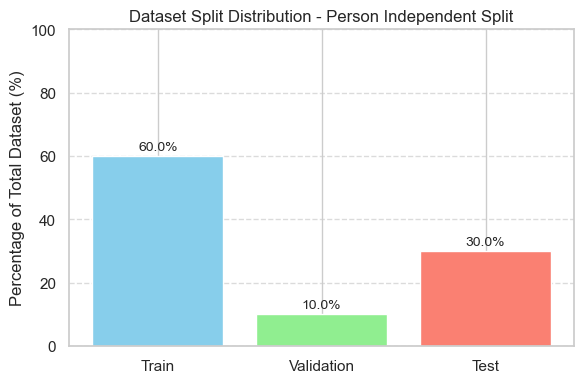

In [13]:
import matplotlib.pyplot as plt

# Sizes
total_size = len(df)
train_size = len(train_pi)
val_size = len(val_pi)
test_size = len(test_pi)

# Compute percentages
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']
percentages = [s / total_size * 100 for s in sizes]

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, percentages, color=['skyblue', 'lightgreen', 'salmon'])

# Add percentage labels on top of bars
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Percentage of Total Dataset (%)')
plt.title('Dataset Split Distribution - Person Independent Split')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

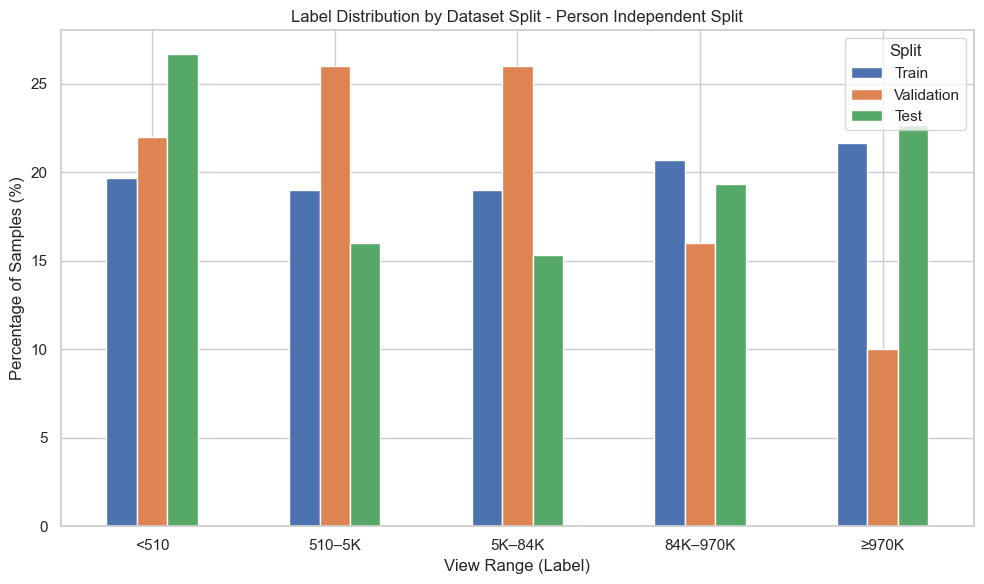

In [14]:
import seaborn as sns

# Helper to compute percentage distribution
def compute_label_percentages(y):
    return y.value_counts(normalize=True).sort_index() * 100  # Percentage

# Compute distributions
train_dist = compute_label_percentages(train_pi['view_range_ind'])
val_dist = compute_label_percentages(val_pi['view_range_ind'])
test_dist = compute_label_percentages(test_pi['view_range_ind'])

# Combine into one DataFrame for plotting
dist_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0).T  # Transpose to have splits as rows

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

dist_df.T.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Percentage of Samples (%)')
plt.xlabel('View Range (Label)')
plt.title('Label Distribution by Dataset Split - Person Independent Split')
plt.xticks(rotation=0)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

# Person-Dependent Split

In [15]:
def person_dependent_split(
    df,
    test_size=0.30,
    val_size=0.10,              # overall desired val share
    count_col="view_count",
    n_bins=5,
    random_state=42
):
    # 1) Hold out test (no labels)
    trainval_df, test_df = initial_test_split_person_dependent(
        df, test_size=test_size, random_state=random_state
    )

    # 2) Learn bins from train+val only
    edges, labels = make_bins_from_train(trainval_df[count_col], n_bins=n_bins)

    # 3) Label train+val and test (test labels are for evaluation/reporting only)
    trainval_df = trainval_df.copy()
    test_df = test_df.copy()
    trainval_df["view_range_dep"] = pd.cut(trainval_df[count_col], bins=edges, labels=labels, include_lowest=True) # Human-readable categorical labels
    test_df["view_range_dep"]     = pd.cut(test_df[count_col],     bins=edges, labels=labels, include_lowest=True)
    df["view_range_dep"] = pd.cut(df[count_col], bins=edges, labels=labels, include_lowest=True)  # Change the entire DF and save for later usage

    enc_pd = make_encoded_labels(edges)
    trainval_df = trainval_df.copy()
    test_df = test_df.copy()
    trainval_df["view_range_enc_dep"] = pd.cut(trainval_df[count_col], bins=edges, labels=enc_pd, include_lowest=True)
    test_df["view_range_enc_dep"]     = pd.cut(test_df[count_col],     bins=edges, labels=enc_pd, include_lowest=True)
    df["view_range_enc_dep"] = pd.cut(df[count_col], bins=edges, labels=enc_pd, include_lowest=True)
    
    # 4) Split train vs val with stratify on train+val labels
    val_rel = val_size / (1.0 - test_size)
    train_df, val_df = train_test_split(
        trainval_df,
        test_size=val_rel,
        random_state=random_state,
        shuffle=True,
        stratify=trainval_df["view_range_dep"]
    )
    
    # Save for later
    train_df.to_parquet("train_df_dep.parquet", index=False)
    val_df.to_parquet("val_df_dep.parquet", index=False)
    test_df.to_parquet("test_df_dep.parquet", index=False)

    # Report class balance
    report_counts("Train (PD)", train_df["view_range_dep"])
    report_counts("Val   (PD)", val_df["view_range_dep"])
    report_counts("Test  (PD)", test_df["view_range_dep"])

    return train_df, val_df, test_df, edges, labels

In [16]:
# PERSON-DEPENDENT (channel-disjoint) 60/10/30 with quantile bins from train+val:
train_pd, val_pd, test_pd, edges_pd, labels_pd = person_dependent_split(
        df,
        test_size=0.30,
        val_size=0.10,
        count_col="view_count",
        n_bins=5,
        random_state=42
    )


Train (PD) class counts:
view_range_dep
<380      59
380–5K    60
5K–89K    60
89K–1M    60
≥1M       60

Val   (PD) class counts:
view_range_dep
<380      11
380–5K    10
5K–89K    10
89K–1M    10
≥1M       10

Test  (PD) class counts:
view_range_dep
<380      26
380–5K    35
5K–89K    27
89K–1M    39
≥1M       23


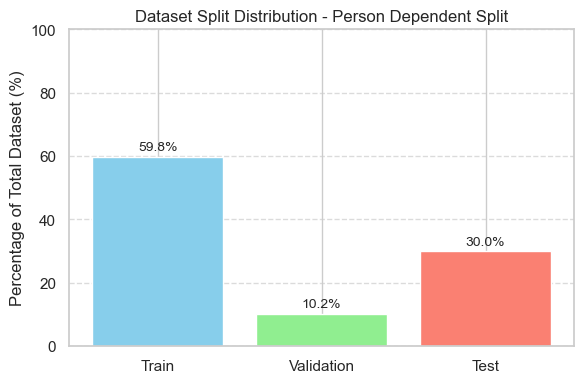

In [17]:
import matplotlib.pyplot as plt

# Sizes
total_size = len(df)
train_size = len(train_pd)
val_size = len(val_pd)
test_size = len(test_pd)

# Compute percentages
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']
percentages = [s / total_size * 100 for s in sizes]

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, percentages, color=['skyblue', 'lightgreen', 'salmon'])

# Add percentage labels on top of bars
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Percentage of Total Dataset (%)')
plt.title('Dataset Split Distribution - Person Dependent Split')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

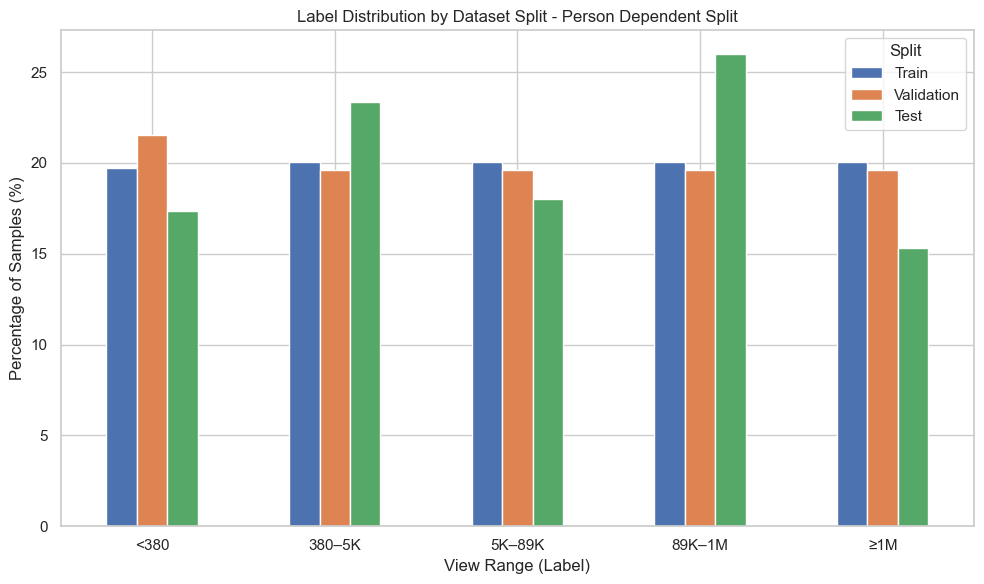

In [9]:
import seaborn as sns

# Helper to compute percentage distribution
def compute_label_percentages(y):
    return y.value_counts(normalize=True).sort_index() * 100  # Percentage

# Compute distributions
train_dist = compute_label_percentages(train_pd['view_range_dep'])
val_dist = compute_label_percentages(val_pd['view_range_dep'])
test_dist = compute_label_percentages(test_pd['view_range_dep'])

# Combine into one DataFrame for plotting
dist_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0).T  # Transpose to have splits as rows

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

dist_df.T.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Percentage of Samples (%)')
plt.xlabel('View Range (Label)')
plt.title('Label Distribution by Dataset Split - Person Dependent Split')
plt.xticks(rotation=0)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

In [18]:
df.to_csv("FinalDataset.csv", index=False)

# Split the Frame Folders

We will split the extracted frames into different folders. This makes it easier for retrieval.

In [91]:
import os
import shutil

def split_video_folders(video_ids, source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)   # Make the target directory
    for vid in video_ids:
        src = os.path.join(source_dir, vid)
        dst = os.path.join(target_dir, vid)

        if not os.path.exists(src):
            print(f"Warning: Folder {src} not found.")
            continue

        if os.path.exists(dst):
            print(f"Skipping: {dst} already exists.")
            continue

        shutil.copytree(src, dst)   # Copy the file from frames folder to the respective split folder

video_ids_train_pi = train_pi['video_id'].tolist()
video_ids_val_pi = val_pi['video_id'].tolist()
video_ids_test_pi = test_pi['video_id'].tolist()

# Person Independent Split
split_video_folders(video_ids_train_pi, "frames", "Person-Independent_Split/train")
split_video_folders(video_ids_val_pi, "frames", "Person-Independent_Split/val")
split_video_folders(video_ids_test_pi, "frames", "Person-Independent_Split/test")

video_ids_train_pd = train_pd['video_id'].tolist()
video_ids_val_pd = val_pd['video_id'].tolist()
video_ids_test_pd = test_pd['video_id'].tolist()

# Person Dependent Split
split_video_folders(video_ids_train_pd, "frames", "Person-Dependent_Split/train")
split_video_folders(video_ids_val_pd, "frames", "Person-Dependent_Split/val")
split_video_folders(video_ids_test_pd, "frames", "Person-Dependent_Split/test")

Skipping: Person-Independent_Split/train\_FlnHuEYDKU already exists.
Skipping: Person-Independent_Split/train\_HQ_WnXewx4 already exists.
Skipping: Person-Independent_Split/train\_KiF7KLVQxU already exists.
Skipping: Person-Independent_Split/train\_oIUVEFNyM4 already exists.
Skipping: Person-Independent_Split/train\0GPULft-U1o already exists.
Skipping: Person-Independent_Split/train\0ip-X7uGZc8 already exists.
Skipping: Person-Independent_Split/train\0jgeKa5AgO4 already exists.
Skipping: Person-Independent_Split/train\0Wo3WV1ueJY already exists.
Skipping: Person-Independent_Split/train\1DTmkkZC64A already exists.
Skipping: Person-Independent_Split/train\1fJKtkOCl_8 already exists.
Skipping: Person-Independent_Split/train\1XUUi4gMau4 already exists.
Skipping: Person-Independent_Split/train\2KwQ7mYVQeQ already exists.
Skipping: Person-Independent_Split/train\2pB9TFUbfIM already exists.
Skipping: Person-Independent_Split/train\2qs5z7SPMx8 already exists.
Skipping: Person-Independent_Split